In [96]:
from math import sqrt as sqrt
import matplotlib.pyplot as plt
import random
import numpy as np 
import pandas as pd

# Helper Functions

In [97]:
def parse_p_median(file, target_id, target_best_value):
    with open(file,"r") as f:
        lines = [line.strip() for line in f if line.strip()]
    i=0
    while i<len(lines):
        parts=lines[i].split()
        if len(parts)==2:
            current_id=int(parts[0])
            current_best_value=int(parts[1])
        if current_id==target_id and current_best_value==target_best_value:
            constraints=lines[i+1].split()
            number_of_customers=int(constraints[0])
            number_of_medians=int(constraints[1])
            capacity_of_medians=int(constraints[2])
            customers=[]
            for j in range(i+2,i+2+number_of_customers):
                each_line=lines[j].split()
                customers.append({
                    "id": int(each_line[0])-1,
                    "x_coordinate":float(each_line[1]),
                    "y_coordinate":float(each_line[2]),
                    "demand":int(each_line[3])
                })
            return {
                "number_of_medians":number_of_medians,
                "capacity_of_medians":capacity_of_medians,
                "customers":customers
            }
        i+=1
    return None
        

# SPEA Algorithm

# Constraints

In [98]:
#Constraints- we have a fixed number of facilities to place and each facility has a maximum capacity
def constraints(chosen_facilities, all_customers,dist_matrix,max_capacity):
    remaining_capacity={m_id:max_capacity for m_id in chosen_facilities}
    total_service_distance=0
    sorted_customers=sorted(all_customers,key=lambda k:k['demand'],reverse=True)
    for customer in sorted_customers:
        customer_id=customer['id']
        distances=[]
        for facility in chosen_facilities:
            d=dist_matrix[customer_id][facility]
            distances.append((facility,d))
        distances.sort(key=lambda x:x[1])
        assigned=False
        for facility_id, dist in distances:
            if remaining_capacity[facility_id]>=customer['demand']:
                remaining_capacity[facility_id]-=customer['demand']
                total_service_distance+=dist
                assigned=True
                break
        if not assigned:
            return float('inf'), 0
    return total_service_distance, True
def dispersion(chosen_facilities,dist_matrix):
    total_dispersion=0
    p=len(chosen_facilities)
    for i in range(p):
        for j in range (i+1,p):
            m1=chosen_facilities[i]
            m2=chosen_facilities[j]
            total_dispersion+=dist_matrix[m1][m2]
    return total_dispersion
#Objective A- minimize facility distance(we want them to be as close to their respective customers as possible)
#Objective B- we want the facilities to be spread far apart from each other

# Algorithm

In [99]:
def population_initialization(population_size,number_of_facilities,customer_data,number_of_customer,dist_matrix,max_capacity):
   population=[]
   while len(population)<population_size:
      candidate_genes=random.sample(range(number_of_customer),number_of_facilities)
      dist_score,feasibility=constraints(candidate_genes,customer_data,dist_matrix,max_capacity)
      if feasibility==True:
         dispersion_score=dispersion(candidate_genes,dist_matrix)
         individual={
            "genes":candidate_genes,
            "distance_score":dist_score,
            "dispersion_score":dispersion_score
         }
         population.append(individual)
         print(f"Found individual {len(population)}/{pop_size}")
   return population
def dominance_function(population):
   for i in range(len(population)):
      count=0
      individual_a=population[i]
      for j in range(len(population)):
         if i==j:
            continue
         individual_b=population[j]
         if ((individual_a['distance_score'] <= individual_b['distance_score']) and (individual_a['dispersion_score']>individual_b['dispersion_score'])) or ((individual_a['distance_score'] < individual_b['distance_score']) and (individual_a['dispersion_score']>=individual_b['dispersion_score'])):
            count+=1
      individual_a['strength']=count
   return population
def raw_fitness(population):
   population=dominance_function(population)
   for i in range(len(population)):
      raw_score=0
      individual_a=population[i]
      for j in range(len(population)):
         if i==j:
            continue
         individual_b=population[j]
         if ((individual_a['distance_score'] >= individual_b['distance_score']) and (individual_a['dispersion_score']<individual_b['dispersion_score'])) or ((individual_a['distance_score'] > individual_b['distance_score']) and (individual_a['dispersion_score']<=individual_b['dispersion_score'])):
            raw_score+=individual_b['strength']
      individual_a['raw_score']=raw_score
   return population
def euclidean_distance(x1, y1, x2, y2):
   return math.sqrt(((x1-y1)**2)+((x2-y2)**2))
def density_function(population,archive,population_size):
   merge=population+archive
   for i in range(len(merge)):
      all_distances=[]
      individual_a=merge[i]
      for j in range(len(merge)):
         individual_b=merge[j]
         if i==j:
            continue
         distance= euclidean_distance(individual_a['distance_score'],individual_b['distance_score'],individual_a['dispersion_score'],individual_b['dispersion_score'])
         all_distances.append(distance)
      all_distances.sort()
      k=int(sqrt(population_size))
      density=1/(all_distances[k]+2)
      individual_a['final_fitness']=individual_a['raw_score']+density
def truncate_archive(archive, archive_size):
   while len(archive)>archive_size:
      neighbour_distances=[]
      for i in range(len(archive)):
         all_distances=[]
         individual_a=archive[i]
         for j in range(len(archive)):
            individual_b=archive[j]
            if i==j:
               continue
            distance= euclidean_distance(individual_a['distance_score'],individual_b['distance_score'],individual_a['dispersion_score'],individual_b['dispersion_score'])
            all_distances.append(distance)
         all_distances.sort()
         neighbour_distances.append(all_distances)
      victim_index = neighbour_distances.index(min(neighbour_distances))
      archive.pop(victim_index)
   return archive      
def environmental_selection(final_population, archive_size):
   new_archive=[ind for ind in final_population if ind['final_fitness']<1]
   if len(new_archive)==archive_size:
      return new_archive
   elif len(new_archive)<archive_size:
      dominated_individuals=[ind for ind in final_population if ind['final_fitness']>=1]
      dominated_individuals.sort(key=lambda x:x['final_fitness'])
      needed_individuals=archive_size-len(new_archive)
      new_archive.extend(dominated_individuals[:needed_individuals])
      return new_archive
   elif len(new_archive)>archive_size:
      return truncate_archive(new_archive,archive_size)
def binary_tournament(archive, population_size, p, number_of_facilities,customer_data,dist_matrix,max_capacity):
   population=[]
   while(len(population)<population_size):
      individual_a=random.choice(archive)
      individual_b=random.choice(archive)
      if individual_a['final_fitness']<individual_b['final_fitness']:
         parent_a=individual_a
      else:
         parent_a=individual_b
      individual_c=random.choice(archive)
      individual_d=random.choice(archive)
      if individual_c['final_fitness']<individual_d['final_fitness']:
         parent_b=individual_c
      else:
         parent_b=individual_d
      #Crossover
      gene_pool = list(set(parent_a['genes'] + parent_b['genes']))
      if len(gene_pool)>=p:
         child_genes = random.sample(gene_pool, p)
      else:
         child_genes = parent_a['genes'][:]
      #Mutation
      if random.random() < 0.10:
         mutate_idx = random.randint(0, p - 1)
         available = [f for f in range(number_of_facilities) if f not in child_genes]
         if available:
            child_genes[mutate_idx] = random.choice(available)
      dist_score, is_feasible = constraints(child_genes, customer_data, dist_matrix, max_capacity)
      if is_feasible:
         dispersion_score=dispersion(child_genes,dist_matrix)
         child = {
                'genes': child_genes,
                'distance_score': dist_score,
                'dispersion_score': dispersion_score
            }
         population.append(child)
   return population

Generating initial valid population...
Found individual 1/50
Found individual 2/50
Found individual 3/50
Found individual 4/50
Found individual 5/50
Found individual 6/50
Found individual 7/50
Found individual 8/50
Found individual 9/50
Found individual 10/50
Found individual 11/50
Found individual 12/50
Found individual 13/50
Found individual 14/50
Found individual 15/50
Found individual 16/50
Found individual 17/50
Found individual 18/50
Found individual 19/50
Found individual 20/50
Found individual 21/50
Found individual 22/50
Found individual 23/50
Found individual 24/50
Found individual 25/50
Found individual 26/50
Found individual 27/50
Found individual 28/50
Found individual 29/50
Found individual 30/50
Found individual 31/50
Found individual 32/50
Found individual 33/50
Found individual 34/50
Found individual 35/50
Found individual 36/50
Found individual 37/50
Found individual 38/50
Found individual 39/50
Found individual 40/50
Found individual 41/50
Found individual 42/50
Foun

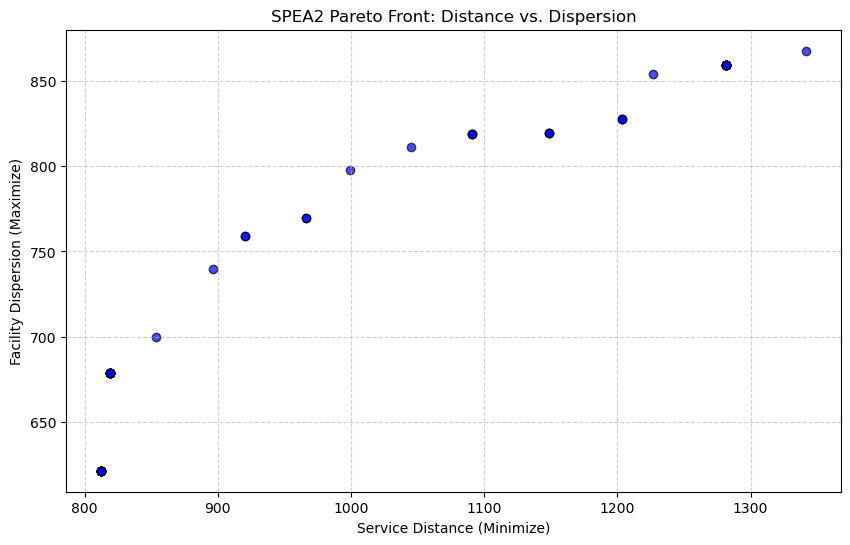

In [ ]:
def build_distance_matrix(customers):
    n = len(customers)
    matrix = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            d = math.sqrt(
                (customers[i]['x_coordinate'] - customers[j]['x_coordinate'])**2 + 
                (customers[i]['y_coordinate'] - customers[j]['y_coordinate'])**2
            )
            matrix[i][j] = d
            matrix[j][i] = d
    return matrix

raw_data = parse_p_median("p_median_capacitated.txt", 1, 713)

if raw_data:
    customer_data = raw_data['customers']
    number_of_customers = len(customer_data)
    number_of_facilities = number_of_customers 
    max_capacity = raw_data['capacity_of_medians']
    p_to_select = raw_data['number_of_medians']
    dist_matrix = build_distance_matrix(customer_data)
    capacity_list = [max_capacity] * number_of_facilities
    demand_list = [c['demand'] for c in customer_data]
else:
    print("Instance not found!")
    exit()

#CONFIGURATION
POP_SIZE = 50
ARCHIVE_SIZE = 50
MAX_GENS = 50

print("Generating initial valid population...")
population = population_initialization(
    POP_SIZE, p_to_select, customer_data, number_of_customers, dist_matrix, max_capacity
)
archive = []

print(f"Starting Evolution...")

for gen in range(MAX_GENS):
    combined = population + archive
    combined = raw_fitness(combined) 
    density_function(population, archive, POP_SIZE)
    archive = environmental_selection(combined, ARCHIVE_SIZE)
    
    if not archive:
        print(f"Gen {gen:03} | Archive is empty - searching for better solutions...")
        combined.sort(key=lambda x: x.get('final_fitness', 999))
        archive = combined[:ARCHIVE_SIZE]
    else:
        current_min_dist = min(ind['distance_score'] for ind in archive)
        current_max_disp = max(ind['dispersion_score'] for ind in archive)
        print(f"Gen {gen:03} | Best Distance: {current_min_dist:.2f} | Max Dispersion: {current_max_disp:.2f}")
    
    population = binary_tournament(
    archive, POP_SIZE, p_to_select, number_of_facilities,
    customer_data, dist_matrix, max_capacity 
)
print("\nOptimization Complete.")

def plot_results(archive):
    dists = [ind['distance_score'] for ind in archive]
    disps = [ind['dispersion_score'] for ind in archive]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(dists, disps, c='blue', edgecolors='k', alpha=0.7)
    plt.title('SPEA2 Pareto Front: Distance vs. Dispersion')
    plt.xlabel('Service Distance (Minimize)')
    plt.ylabel('Facility Dispersion (Maximize)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_results(archive)

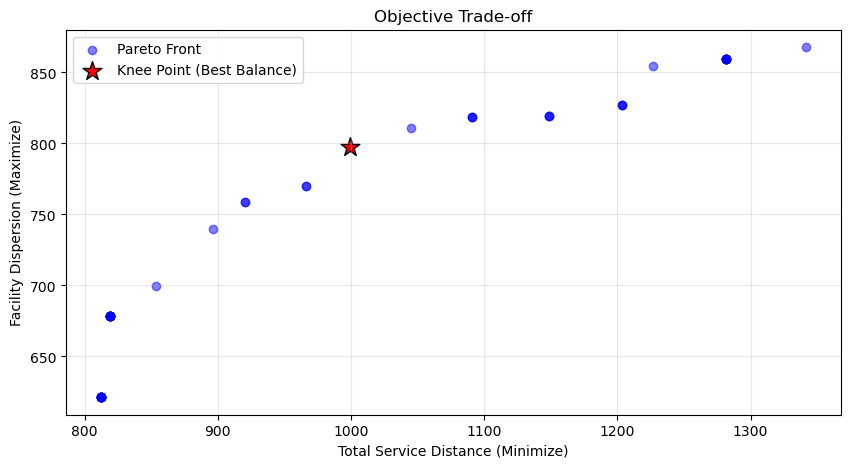

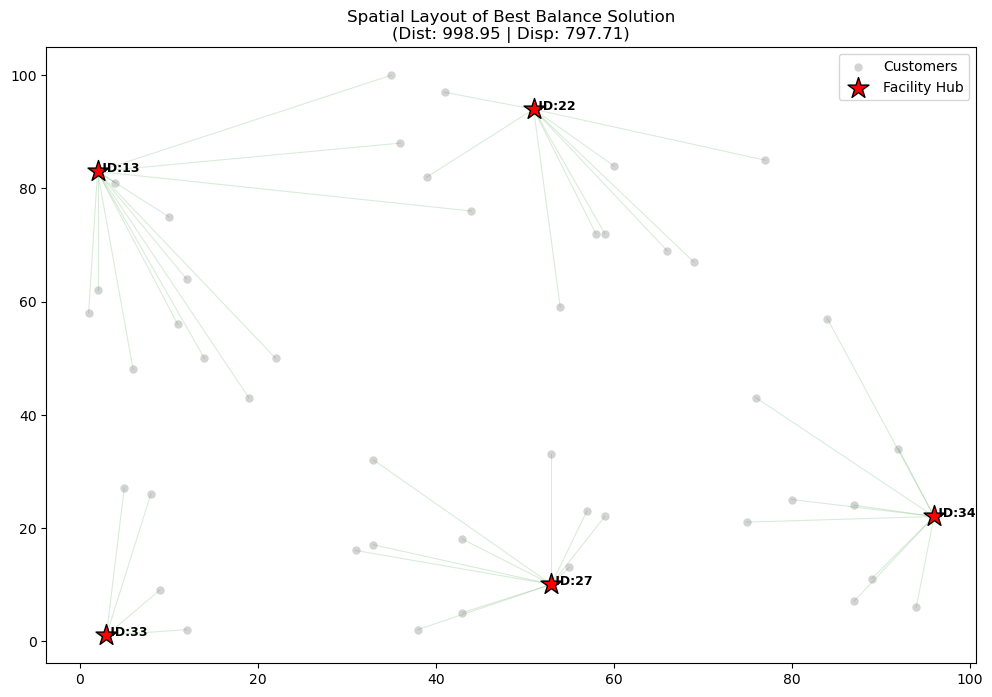

In [101]:
def plot_final_analysis(archive, customer_data, dist_matrix, max_capacity):
    data = []
    for ind in archive:
        data.append({
            'Distance': ind['distance_score'],
            'Dispersion': ind['dispersion_score']
        })
    df = pd.DataFrame(data)

    # Normalize to find the best balance (Min Distance, Max Dispersion)
    dist_min, dist_max = df['Distance'].min(), df['Distance'].max()
    disp_min, disp_max = df['Dispersion'].min(), df['Dispersion'].max()
    
    df['dist_norm'] = (df['Distance'] - dist_min) / (dist_max - dist_min + 1e-6)
    df['disp_norm'] = (df['Dispersion'] - disp_min) / (disp_max - disp_min + 1e-6)
    
    # Distance to the "Ideal" point (0, 1)
    df['dist_to_ideal'] = np.sqrt(df['dist_norm']**2 + (1 - df['disp_norm'])**2)
    knee_idx = df['dist_to_ideal'].idxmin()
    best_ind = archive[knee_idx]

    #GRAPH A: ANNOTATED PARETO FRONT
    plt.figure(figsize=(10, 5))
    plt.scatter(df['Distance'], df['Dispersion'], c='blue', label='Pareto Front', alpha=0.5)
    plt.scatter(best_ind['distance_score'], best_ind['dispersion_score'], 
                c='red', marker='*', s=200, label='Knee Point (Best Balance)', edgecolors='black')
    plt.title("Objective Trade-off")
    plt.xlabel("Total Service Distance (Minimize)")
    plt.ylabel("Facility Dispersion (Maximize)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # GRAPH B: SPATIAL ASSIGNMENT MAP
    chosen_facilities = best_ind['genes']
    remaining_capacity = {f_id: max_capacity for f_id in chosen_facilities}
    assignments = []
    
    sorted_customers = sorted(customer_data, key=lambda k: k['demand'], reverse=True)
    for customer in sorted_customers:
        c_id = customer['id']
        fac_dists = sorted([(f, dist_matrix[c_id][f]) for f in chosen_facilities], key=lambda x: x[1])
        for f_id, _ in fac_dists:
            if remaining_capacity[f_id] >= customer['demand']:
                remaining_capacity[f_id] -= customer['demand']
                assignments.append((c_id, f_id))
                break

    plt.figure(figsize=(12, 8))
    
    # Plot Customers
    cust_x = [c['x_coordinate'] for c in customer_data]
    cust_y = [c['y_coordinate'] for c in customer_data]
    plt.scatter(cust_x, cust_y, c='lightgray', s=25, label='Customers', zorder=1)
    
    for c_id, f_id in assignments:
        c_node = next(c for c in customer_data if c['id'] == c_id)
        f_node = next(c for c in customer_data if c['id'] == f_id)
        plt.plot([c_node['x_coordinate'], f_node['x_coordinate']], 
                 [c_node['y_coordinate'], f_node['y_coordinate']], 
                 'g-', alpha=0.15, linewidth=0.8, zorder=2)

    # Plot Selected Facilities
    for f_id in chosen_facilities:
        f_node = next(c for c in customer_data if c['id'] == f_id)
        plt.scatter(f_node['x_coordinate'], f_node['y_coordinate'], 
                    c='red', marker='*', s=250, edgecolors='black', label='Facility Hub' if f_id == chosen_facilities[0] else "", zorder=3)
        plt.text(f_node['x_coordinate'], f_node['y_coordinate'], f" ID:{f_id}", fontsize=9, fontweight='bold')

    plt.title(f"Spatial Layout of Best Balance Solution\n(Dist: {best_ind['distance_score']:.2f} | Disp: {best_ind['dispersion_score']:.2f})")
    plt.legend()
    plt.show()

# Execute
plot_final_analysis(archive, customer_data, dist_matrix, max_capacity)